# Car Object Detection AI

## Libraries

In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import shutil as sh
import csv

from IPython.display import Image, clear_output, display
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import warnings
warnings.simplefilter("ignore", UserWarning)

## Data Creation & Preprocessing

In [2]:
df = pd.read_csv('./data/train_solution_bounding_boxes.csv')
df['image'] = df['image'].apply(lambda x: x.split('.')[0])

1. Split training_imgaes into val and train
2. ./tmp/images have images and ./tmp/labels have xmin, ymin, xmax, ymax values

In [3]:
index = list(set(df.image))
val_index = index[0:len(index)//5] # [0:71]
for name,info in tqdm(df.groupby('image')):
    if name in val_index:
        save_path = 'val/'
    else:
        save_path = 'train/'
    if not os.path.exists('./tmp/labels/'+save_path):
        os.makedirs('./tmp/labels/'+save_path)
    with open('./tmp/labels/'+save_path+name+".txt", 'w+') as file:
        row = info[['xmin','ymin','xmax','ymax']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            file.write(text)
            file.write("\n")
    if not os.path.exists('./tmp/images/'+save_path):
        os.makedirs('./tmp/images/'+save_path)
    sh.copy("./data/training_images/{}.jpg".format(name),'./tmp/images/{}/{}.jpg'.format(save_path,name))

100%|██████████| 355/355 [00:00<00:00, 1379.72it/s]


In [4]:
IMG_SIZE = 300
WIDTH = 676.0
HEIGHT = 380.0

### Create Training, Validation, and Test data

In [5]:
training_data = []
names = []

def create_training_data():
    for img in tqdm(os.listdir('./tmp/images/train/')):
        names.append(img[:-4])

    names.sort()
    for n in names:
        img_array = cv2.imread('./tmp/images/train/{}.jpg'.format(n))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        lbl_array = np.loadtxt('./tmp/labels/train/{}.txt'.format(n))
        if lbl_array.shape == (4,):
            lbl_array = np.array([lbl_array])
        # else:
        #     obj_num = lbl_array.shape[0]
            # print(n, obj_num)

        training_data.append([img_array, lbl_array])

create_training_data()

100%|██████████| 355/355 [00:00<00:00, 1661805.71it/s]


In [6]:
val_data = []
names = []

def create_val_data():
    for img in tqdm(os.listdir('./tmp/images/val/')):
        names.append(img[:-4])

    for n in names:
        img_array = cv2.imread('./tmp/images/val/{}.jpg'.format(n))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        lbl_array = np.loadtxt('./tmp/labels/val/{}.txt'.format(n))
        if lbl_array.shape == (4,):
            lbl_array = np.array([lbl_array])
        # else:
        #     obj_num = lbl_array.shape[0]
            # print(n, obj_num)

        val_data.append([img_array, lbl_array])

create_val_data()

100%|██████████| 354/354 [00:00<00:00, 2951856.10it/s]


In [7]:
np.random.shuffle(training_data)
np.random.shuffle(val_data)

In [8]:
x_train = []
y_train  = []
y_temp = []

for features,label in training_data:
    obj_num = label.shape[0]
    for i in range(obj_num):
        x_train.append(features)
        y_temp.append(label[i])

print(len(y_temp))

for i in range(len(y_temp)):
    y_temp[i][0] = y_temp[i][0]/(WIDTH/IMG_SIZE)
    y_temp[i][1] = y_temp[i][1]/(HEIGHT/IMG_SIZE)
    y_temp[i][2] = y_temp[i][2]/(WIDTH/IMG_SIZE)
    y_temp[i][3] = y_temp[i][3]/(HEIGHT/IMG_SIZE)

x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_train = np.array(y_temp)

559


In [9]:
x_val = []
y_val  = []
y_temp = []

for features,label in val_data:
    obj_num = label.shape[0]
    for i in range(obj_num):
        x_val.append(features)
        y_temp.append(label[i])

for i in range(len(y_temp)):
    y_temp[i][0] = y_temp[i][0]/(HEIGHT/IMG_SIZE)
    y_temp[i][1] = y_temp[i][1]/(WIDTH/IMG_SIZE)
    y_temp[i][2] = y_temp[i][2]/(HEIGHT/IMG_SIZE)
    y_temp[i][3] = y_temp[i][3]/(WIDTH/IMG_SIZE)

x_val = np.array(x_val).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_val = np.array(y_temp)

[  8.30298616 151.90657382  43.48142753 182.60605571]
[279.89803349 142.19154789 300.         169.00501942]
[115.48480464 155.38127416 168.01736614 187.04150582]
[232.70211217 132.47652205 262.63656226 158.12419042]
[123.08248913 135.30405403 189.2908828  186.26930503]
[ 71.20115774 155.38127416 148.04630969 203.257722  ]
[187.33719249 139.55115829 252.67727929 184.33880305]
[ 72.28654123 126.42374518 139.79739506 181.24999997]
[245.94790158 139.16505789 300.         188.19980692]
[187.77134587 145.72876445 246.38205501 179.31949808]


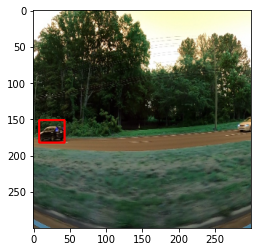

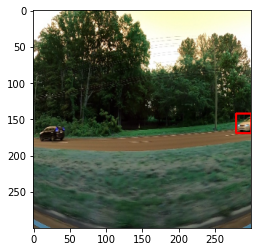

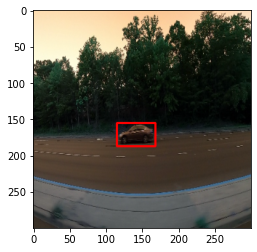

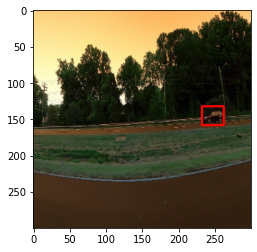

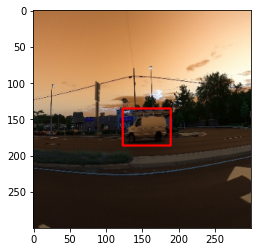

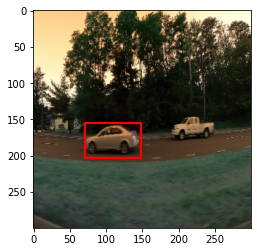

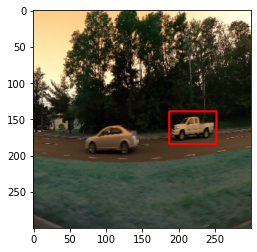

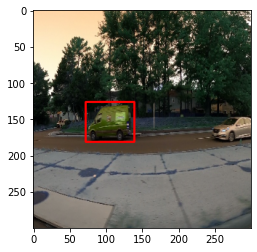

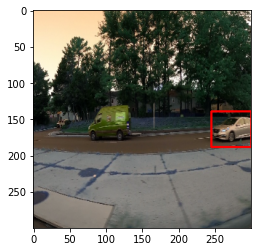

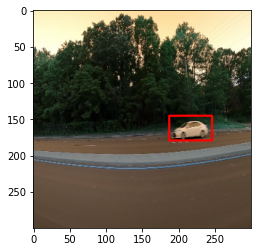

In [10]:
for i in range(10):
    color = (255,0,0)
    thickness = 2
    cv2.rectangle(x_train[i], (int(y_train[i][0]),int(y_train[i][1])), (int(y_train[i][2]),int(y_train[i][3])), color, thickness)
    plt.figure()
    plt.imshow(x_train[i])
    print(y_train[i])

## Training

### Create Model

In [11]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=x_train.shape[1:]))
# model.add(tf.keras.layers.MaxPool2D())
# model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
# model.add(tf.keras.layers.MaxPool2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(units=120, activation='relu'))
# model.add(tf.keras.layers.Dense(units=84, activation='relu'))
# model.add(tf.keras.layers.Dense(units=y_train.shape[1], activation = 'softmax'))

# print(model.summary())

In [12]:
# model = Sequential()

# model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(64))
# model.add(Activation('relu'))

# model.add(Dense(4))
# model.add(Activation('sigmoid'))

# print(model.summary())

In [13]:
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [14]:
# load the VGG16 network, ensuring the head FC layers are left off
resnet = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
# flatten the max-pooling output of VGG
flatten = resnet.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
# bboxHead = Dense(128, activation="relu")(flatten)
# bboxHead = Dense(64, activation="relu")(bboxHead)
# bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4)(flatten)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=resnet.input, outputs=bboxHead)


model.compile(loss='mse',
              optimizer='adam',metrics=['accuracy'])
              #metrics=[tf.keras.metrics.MeanSquaredError()])

2022-04-25 05:19:56.384440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-25 05:19:56.384577: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



### Train Model

In [15]:
learning_rate = 0.0001
batch_size = 32
num_epochs = 10

In [16]:
NAME = 'Car-Object-Detection-{}'.format(int(time.time()))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(NAME))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_data = (x_val, y_val), callbacks=[tensorboard, model_save])

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val, y_val, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

Epoch 1/10


2022-04-25 05:19:57.370580: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-25 05:19:58.699266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 6141.3760 - accuracy: 0.6601

2022-04-25 05:20:20.472822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 29s 1s/step - loss: 6141.3760 - accuracy: 0.6601 - val_loss: 4500982.0000 - val_accuracy: 0.5018
Epoch 2/10
18/18 [==============================] - 20s 1s/step - loss: 3100.9016 - accuracy: 0.7370 - val_loss: 46657.7539 - val_accuracy: 0.1900
Epoch 3/10
18/18 [==============================] - 19s 1s/step - loss: 2631.4424 - accuracy: 0.7603 - val_loss: 26585.2715 - val_accuracy: 0.2634
Epoch 4/10
18/18 [==============================] - 19s 1s/step - loss: 2290.0859 - accuracy: 0.7764 - val_loss: 30779.3984 - val_accuracy: 0.2312
Epoch 5/10
18/18 [==============================] - 19s 1s/step - loss: 2243.1079 - accuracy: 0.7871 - val_loss: 23492.1875 - val_accuracy: 0.2616
Epoch 6/10
18/18 [==============================] - 20s 1s/step - loss: 2264.7588 - accuracy: 0.7996 - val_loss: 19657.4336 - val_accuracy: 0.5556
Epoch 7/10
18/18 [==============================] - 19s 1s/step - loss: 2339.1143 - accuracy: 0.7979 - val_loss: 21828.0938 - v

## Prediction

In [17]:
def predict_random():
    testing_names = []
    for img in os.listdir('./data/testing_images'):
        testing_names.append(img)

    img_name = testing_names[random.randrange(0, len(testing_names))]
    filepath = './data/testing_images/{}'.format(img_name)

    raw_image = cv2.imread(filepath)
    img_array = cv2.resize(raw_image, (IMG_SIZE, IMG_SIZE))
    photo = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    prediction = model.predict(photo)

    # plt.imshow(raw_image)
    # plt.show()
    print(prediction)


    #point1 = int(prediction[0][0]*(WIDTH/IMG_SIZE)),int(prediction[0][1]*(WIDTH/IMG_SIZE))
    #point2 = int(prediction[0][2]*(WIDTH/IMG_SIZE)), int(prediction[0][3]*(WIDTH/IMG_SIZE))
    point1 = int(prediction[0][0]), int(prediction[0][1])
    point2 = int(prediction[0][2]), int(prediction[0][3])
    color = (255,0,0)
    thickness = 2

    # print(point1, point2)

    # point1 = 200, 200
    # point2 = 300, 300

    cv2.rectangle(img_array, point1, point2, color, thickness)
    plt.figure()
    plt.imshow(img_array)

def predict_path(file_path):
    raw_image = cv2.imread(file_path)
    img_array = cv2.resize(raw_image, (IMG_SIZE, IMG_SIZE))
    photo = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    prediction = model.predict(photo)
    print(prediction)

    point1 = int(prediction[0][0]), int(prediction[0][1])
    point2 = int(prediction[0][2]), int(prediction[0][3])
    color = (255,0,0)
    thickness = 2

    cv2.rectangle(img_array, point1, point2, color, thickness)
    plt.figure()
    plt.imshow(img_array)

[[197.0255  146.14018 228.53625 166.23051]]
[[ 61.88568  135.57751   94.916336 159.21278 ]]
[[367.7668  143.8058  403.02444 159.4067 ]]
[[ 76.84992 139.11087 116.31491 160.5601 ]]
[[ -2.670755 139.21236   22.007528 150.37596 ]]
[[ 68.49139  124.428116 103.8139   144.44089 ]]
[[310.78326 151.6981  361.47525 171.36931]]
[[114.39124 143.08803 175.2602  178.51962]]
[[ 72.39443 131.49706 106.95918 151.9211 ]]
[[136.34056 144.53703 189.30635 176.09447]]


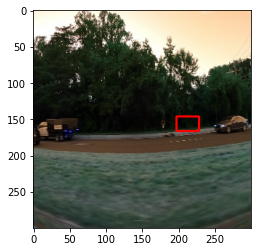

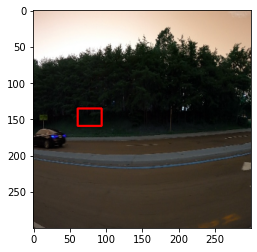

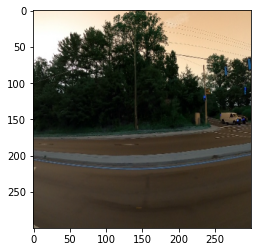

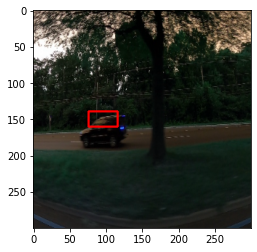

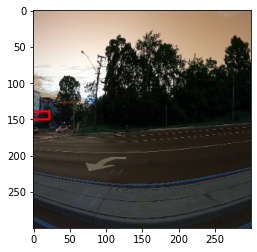

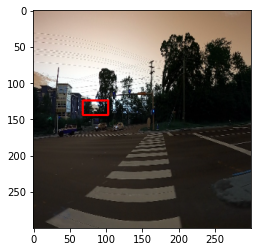

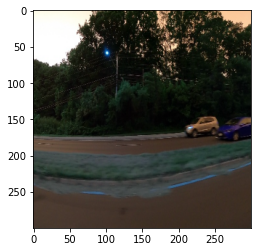

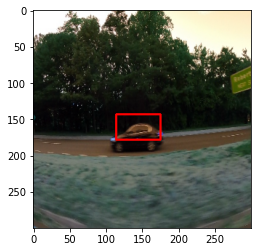

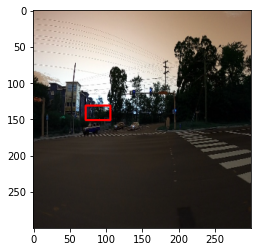

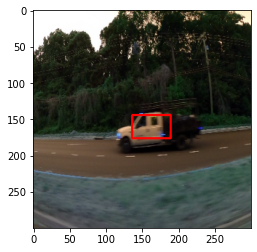

In [21]:
for i in range(10):
    predict_random()

[[ 73.53367 148.22226 133.30676 189.12947]]
[[ -2.670755 139.21236   22.007528 150.37596 ]]
[[310.78326 151.6981  361.47525 171.36931]]
[[239.75072 135.92798 283.65665 159.18587]]
[[ 50.086693 126.08346   82.58622  148.54338 ]]
[[261.4886  127.99341 300.0904  147.69368]]
[[391.7043  144.18486 421.62857 160.93037]]
[[154.17085 147.85297 184.43286 171.29947]]
[[ -9.777796 136.89641   12.918905 148.5124  ]]
[[182.29826 136.44157 244.177   181.46477]]


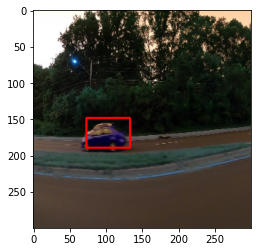

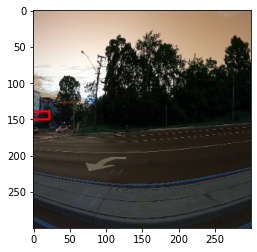

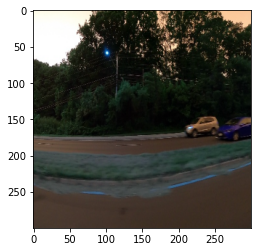

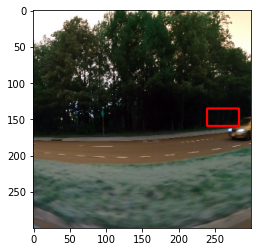

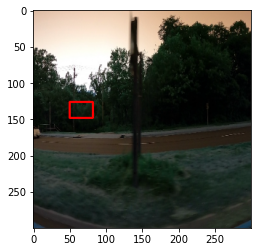

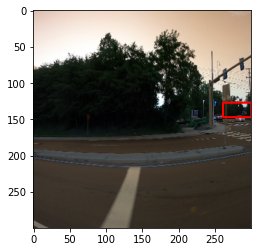

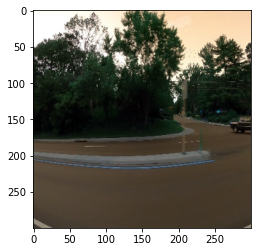

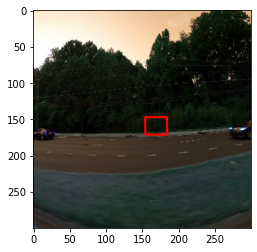

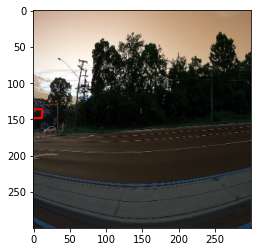

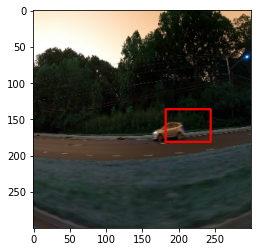

In [20]:
for i in range(10):
    predict_random()

2022-04-25 05:23:31.165209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[ 41.15103 138.9932   78.36601 161.12291]]
[[453.4164  152.16695 488.88065 171.13881]]
[[ 14.34171 146.6588   49.56632 169.01378]]
[[176.40913 136.41454 214.867   161.01978]]
[[310.78326 151.6981  361.47525 171.36931]]
[[119.75376 127.66862 156.91165 145.08167]]
[[140.7188  133.67653 173.93794 150.97398]]
[[ 65.561264 136.9322   104.735245 161.26485 ]]
[[ 68.49139  124.428116 103.8139   144.44089 ]]
[[ 67.00196 140.85677 126.21895 177.59657]]


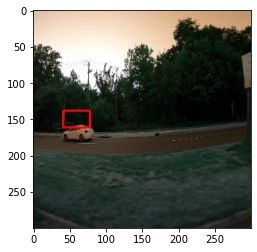

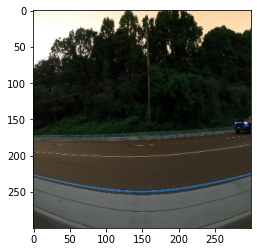

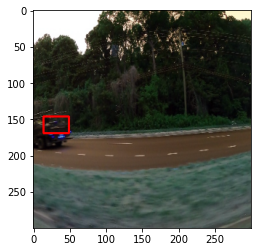

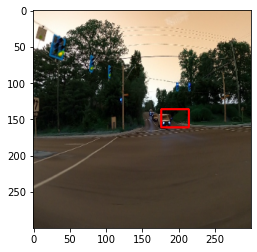

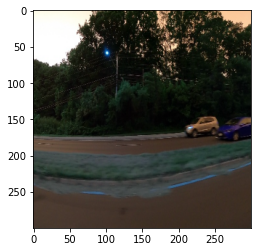

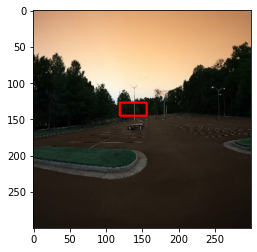

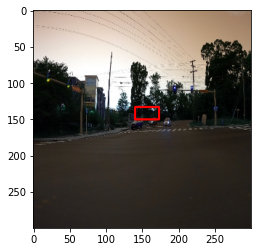

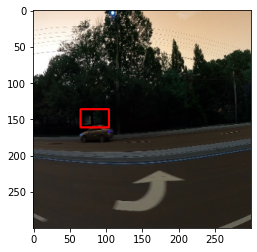

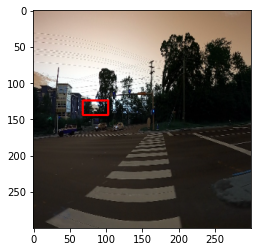

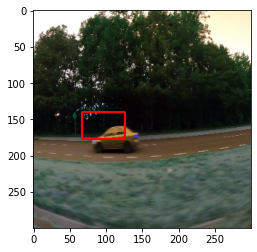

In [18]:
for i in range(10):
    predict_random()